In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [3]:
name_output = input('enter the name of your output file ').strip()

enter the name of your output file Pneunet_try


# Import Modules

In [4]:
import tensorflow as tf

In [5]:
# import tensorflow as tf
# from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Reshape, Activation,Flatten,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision,TruePositives,TrueNegatives, FalsePositives,FalseNegatives,Accuracy

In [6]:
import os
import shutil
import glob

import random
import warnings

# Add GPU

In [7]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
if len(physical_devices) >=1:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPUs Available:  0


# Make Your Edits

In [8]:
## change home directory
home = '/content/drive/MyDrive/Projects/CXR'

image_zip = 'chest_xray.zip'

model_name = 'Pneunet'

this_model_name =  name_output+'.h5'

# Pull Data and Setup

In [9]:
image_path =  'data'

input_dir = 'train'
train_dir = 'data/train'
val_dir = 'data/validate'
held_dir = 'data/withhold'


shutil.copytree(os.path.join(home, 'data','data'), 'data')

'data'

In [10]:
# prompt: check in data the number of items in both folders in train

normal_train_len = len(os.listdir('data/train/NORMAL'))
pneumonia_train_len = len(os.listdir('data/train/PNEUMONIA'))
print('NORMAL:', normal_train_len)
print('PNEUMONIA:', pneumonia_train_len)


NORMAL: 3216
PNEUMONIA: 3100


# Functions

### Plot Confusion Matrix

In [11]:
def plot_confusion_matrix(cm,classes,
                          normalize = False,
                          title='Confusion matrix',
                          cmap = plt.cm.Blues):
  """
  this function prints and plots the confusion matrix
  normalization can be applied by setting normalize=True
  """
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tickmarks=  np.arange(len(classes))
  plt.xticks(tickmarks,classes,rotation=45)
  plt.yticks(tickmarks,classes)
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1) [:,np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('confusion matrix without normalization')

  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(i,j,cm[i,j],
             horizontalalignment='center',
             color = 'white' if cm[i,j] > thresh else 'black'
             )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

# Build Model

In [14]:
import os
import math
import numpy as np
import pickle as p
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
# import tensorflow_addons as tfa
import numpy as np
import tensorflow as tf
from tensorflow import keras
import math
from PIL import Image
import cv2
from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import ResNet50



In [ ]:
from utils.Image_reader import Imagereader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
set_seed(1)
BS = 16
BATCH = BS
SEED = 42
H = 224
W = 224

In [68]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# Define the input layer
input_layer = layers.Input(shape=(224, 224, 1))

# ResNet50 base model
# Using 'include_top=False' to exclude the fully connected layers at the top of the network
resnet = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 1))(input_layer)

# Batch Normalization
x = layers.BatchNormalization()(resnet)

# Global Average Pooling to reduce the spatial dimensions
x = layers.GlobalAveragePooling2D()(x)

# Expand dimensions to simulate (512, 80) structure
x = layers.Dense(512 * 80, activation='relu')(x)
x = layers.Reshape((512, 80))(x)

# Transformer Blocks
def transformer_block(x, num_heads, ff_dim):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    attn_output = layers.LayerNormalization(epsilon=1e-6)(attn_output + x)
    ffn_output = layers.Dense(ff_dim, activation="relu")(attn_output)
    ffn_output = layers.Dense(x.shape[-1], activation="relu")(ffn_output)
    return layers.LayerNormalization(epsilon=1e-6)(ffn_output + attn_output)

# Apply 6 Transformer layers
for _ in range(6):
    x = transformer_block(x, num_heads=8, ff_dim=80)

# Flatten the transformer output
x = layers.Flatten()(x)

# Dropout Layer
x = layers.Dropout(0.5)(x)

# Dense layers with Dropout
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Final Dense Layer for Binary Classification (LogitDense)
output_layer = layers.Dense(2, activation='softmax')(x)

# Define the model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30            │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,581,440 │ input_layer_30[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 7, 7, 2048)     │          8,192 │ resnet50[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_154 (Dense)         │ (None, 40960)          │     83,927,040 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 512, 80)        │              0 │ dense_154[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_54   │ (None, 512, 80)        │        206,800 │ reshape_2[0][0],       │
│ (MultiHeadAttention)      │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_108 (Add)             │ (None, 512, 80)        │              0 │ multi_head_attention_… │
│                           │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_117   │ (None, 512, 80)        │            160 │ add_108[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_155 (Dense)         │ (None, 512, 80)        │          6,480 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_156 (Dense)         │ (None, 512, 80)        │          6,480 │ dense_155[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_109 (Add)             │ (None, 512, 80)        │              0 │ dense_156[0][0],       │
│                           │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_118   │ (None, 512, 80)        │            160 │ add_109[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_55   │ (None, 512, 80)        │        206,800 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_110 (Add)             │ (None, 512, 80)        │              0 │ multi_head_attention_… │
│                      

 Total params: 150,847,890 (575.44 MB)

 Trainable params: 150,790,674 (575.22 MB)

 Non-trainable params: 57,216 (223.50 KB)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 100352)         │              0 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_4 (Encoder)       │ (None, 80)             │      8,028,240 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_52    │ (None, 80)             │            160 │ encoder_4[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_24   │ (None, 80)             │        413,520 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_48 (Add)              │ (None, 80)             │              0 │ multi_head_attention_… │
│                           │                        │                │ encoder_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_53    │ (None, 80)             │            160 │ add_48[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_69 (Dense)          │ (None, 160)            │         12,960 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_89 (Dropout)      │ (None, 160)            │              0 │ dense_69[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_70 (Dense)          │ (None, 80)             │         12,880 │ dropout_89[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_90 (Dropout)      │ (None, 80)             │              0 │ dense_70[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_49 (Add)              │ (None, 80)             │              0 │ dropout_90[0][0],      │
│                           │                        │                │ add_48[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_54    │ (None, 80)             │            160 │ add_49[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_25   │ (None, 80)             │        413,520 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_50 (Add)         

 Total params: 34,403,810 (131.24 MB)

 Trainable params: 34,350,690 (131.04 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [64]:
features.shape

(None, 1, 16)

In [50]:
for layer in model.layers:
    print(f"{layer.name}: {layer.trainable}")


input_layer_16: True
resnet50: True
flatten_6: True
encoder_5: True
layer_normalization_65: True
multi_head_attention_30: True
add_60: True
layer_normalization_66: True
dense_86: True
dropout_111: True
dense_87: True
dropout_112: True
add_61: True
layer_normalization_67: True
multi_head_attention_31: True
add_62: True
layer_normalization_68: True
dense_88: True
dropout_114: True
dense_89: True
dropout_115: True
add_63: True
layer_normalization_69: True
multi_head_attention_32: True
add_64: True
layer_normalization_70: True
dense_90: True
dropout_117: True
dense_91: True
dropout_118: True
add_65: True
layer_normalization_71: True
multi_head_attention_33: True
add_66: True
layer_normalization_72: True
dense_92: True
dropout_120: True
dense_93: True
dropout_121: True
add_67: True
layer_normalization_73: True
multi_head_attention_34: True
add_68: True
layer_normalization_74: True
dense_94: True
dropout_123: True
dense_95: True
dropout_124: True
add_69: True
layer_normalization_75: True
mul

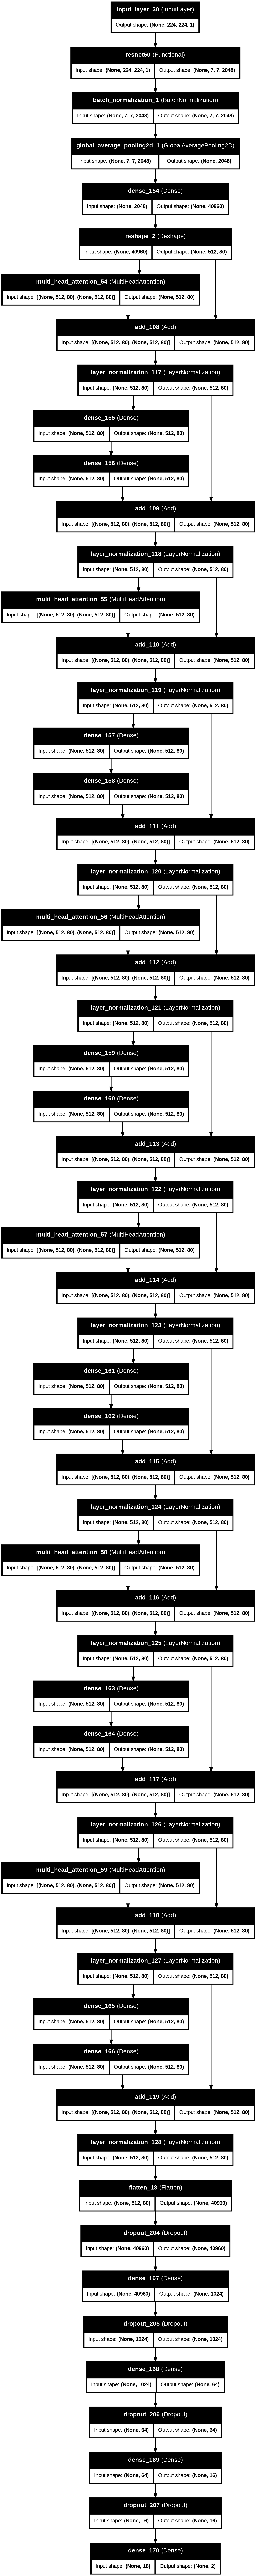

In [69]:
# prompt: plot the model

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


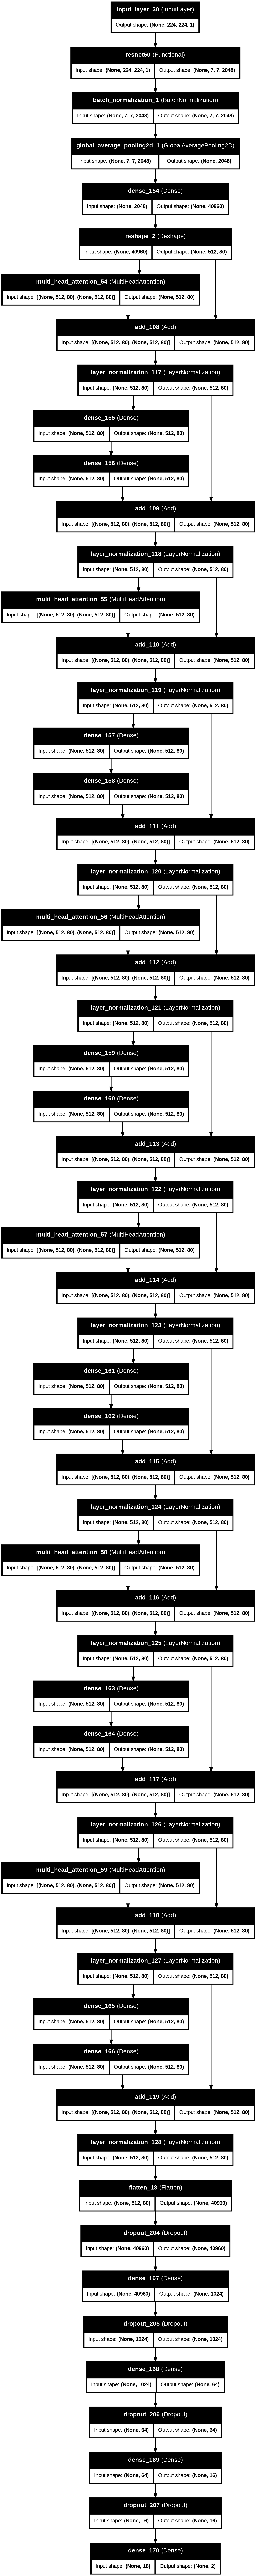

In [70]:
# prompt: ouput the plot of model to file in os.path.join(home,'Outputs','Pneunet.png)

plot_model(model, to_file=os.path.join(home,'Outputs','Pneunet.png'), show_shapes=True, show_layer_names=True)


## Preprocess

# Pull data

In [22]:
train_path = os.path.join(image_path,'train')
valid_path = os.path.join(image_path,'validate')
test_path = os.path.join(image_path,'test')

In [26]:
BS = 16

In [27]:
## add augmentations similar to above one  here
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

train_batches = train_datagen.flow_from_directory(directory= train_path,target_size=(H,W),batch_size=BS, class_mode ='categorical')

valid_batches = val_datagen.flow_from_directory(directory= valid_path,target_size=(H,W),batch_size=BS,  class_mode ='categorical')

test_batches = val_datagen.flow_from_directory(directory= test_path,target_size=(H,W),batch_size=BS, shuffle = False,  class_mode ='categorical')


Found 6316 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [28]:
labels = train_batches.class_indices
print(labels)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
# prompt: plot the model

tf.keras.utils.plot_model(model)


In [29]:
learning_rate=0.0001
weight_decay=0.001

# Train the model

In [71]:
# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [72]:
epochs=  5

In [73]:
History = model.fit(
    x = train_batches,
    validation_data = valid_batches,
    epochs = epochs,
    batch_size = BS,
    verbose=2
    )

Epoch 1/5


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv1_conv" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 230, 230, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
history_df = pd.DataFrame(History.history)

In [ ]:
history_df.to_csv(os.path.join(home,'Outputs',name_output+'.csv'))

# Optionally Load the Model

In [ ]:
# # prompt: Load a saved model and use

# from tensorflow.keras.models import load_model
# # Load the saved model
# model = load_model(os.path.join(home,'models',this_model_name))

# # Now you can use the loaded_model for predictions or further training
# # predictions = loaded_model.predict(test_batches)


# Predict

In [ ]:
test_labels= test_batches.classes

In [ ]:
x_test = np.concatenate([test_batches[i][0] for i in range(len(test_batches))])

In [ ]:
predictions = model.predict(  x = x_test,verbose=0)

In [ ]:
dff = pd.DataFrame(predictions)

In [ ]:
dff['test'] = test_labels
dff.head(10)

# Taking Prediction Probabilities to CSV

In [ ]:
dff.to_csv(os.path.join(home,'Outputs',name_output+'_prediction_probabilities.csv'))

# Confusion Matrix

In [ ]:
y_pred = np.argmax(predictions,axis=-1)
y_true=test_labels

In [ ]:
test_batches.class_indices
cm_plot_labels = [i for i in test_batches.class_indices.keys()]

In [ ]:
# prompt: make confusion matrix from y_pred and y_test store in cm

cm = confusion_matrix(y_true,y_pred)


In [ ]:
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title = 'confusion matrix')

# Metrics

In [ ]:
# prompt: given y_pred and y_true calculate importatnt metrics to 4 dps

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for multiclass
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print metrics to 4 decimal places
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


# Save Model

In [ ]:
model.save(this_model_name)

In [ ]:
model_path = os.path.join(home,'models')
# home = '/content/drive/MyDrive/project/Tensorflow And Keras' #/content/drive/MyDrive/project/Project2.1/Script2_pure classification

In [ ]:
shutil.move(this_model_name,model_path)